In [37]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [38]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import h5py
import json
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy import signal
from functools import reduce
#from imports import *
#from analysis.loading import load_session_data
from session.sessions import selected_009266, selected_008229

import matplotlib.pyplot as plt

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [40]:
#selected_009266
selected_008229

['008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-20_15-54-39',
 '008229_hippoSIT_2022-05-18_14-36-18']

## Read MoSeq source file

In [41]:
#source = '/home/sobolev/nevermind/Miguel/MoSeq/TrainedModels/MoSeqProject_ALLhippoSIT/2023_01_22-16_22_54'
#source = '/home/sobolev/nevermind/Andrey/analysis/DLC/MoSeq/10fps'

source = '/home/sobolev/nevermind/Andrey/analysis/MoSeq/results'
#session = selected_009266[18]
session = selected_008229[3]

filt = [s for s in os.listdir(source) if s.startswith(session)]
if len(filt) > 0:
    moseq_file = os.path.join(source, filt[0])
    print("Found MoSeq file")
else:
    print("No MoSeq file for that session")

Found MoSeq file


In [42]:
ds = pd.read_csv(moseq_file)
ds.head()

syllables reindexed  syllables non-reindexed  centroid x  centroid y  \
0                    0                       82    496.4256    364.0172   
1                    0                       82    497.8193    361.1044   
2                    0                       82    502.6127    359.1499   
3                    0                       82    511.3403    347.9349   
4                    0                       82    519.1863    336.1914   

   heading  estimated left_eye x  estimated left_eye y  estimated right_eye x  \
0  -1.0080              502.2657              348.2704               506.5237   
1  -1.2820              506.8656              342.6798               519.6453   
2  -1.2535              507.2455              339.1818               515.6492   
3  -1.1288              516.3820              327.7793               526.3872   
4  -1.0357              526.0042              316.9872               534.7120   

   estimated right_eye y  estimated left_ear x  ...  estimated right_hip y  \
0               368.8014              489.8594  ...               369.3536   
1               335.4263              496.2881  ...               391.8830   
2               343.7710              499.0871  ...               382.1450   
3               332.2752              508.5156  ...               372.5440   
4               323.6790              517.6688  ...               359.5943   

   latent_state 0  latent_state 1  latent_state 2  latent_state 3  \
0         -2.7934          3.7192         -3.5289          0.2810   
1          3.4440         -1.9281         -6.5356          3.2155   
2          0.1586         -0.1186         -1.7582          0.2075   
3          0.2880         -0.2780         -0.6548          0.2365   
4          0.0007         -0.1615         -0.9146          0.0523   

   latent_state 4  latent_state 5  latent_state 6  latent_state 7  \
0         -1.6455         -0.0245         -1.5734         -1.8662   
1          1.8888          2.5745         -0.2975         -5.4246   
2          0.3197          0.5477          1.1671          1.0197   
3         -0.0354          0.0675          0.6431          0.5104   
4          0.0245         -0.1000          0.3405          0.6065   

   latent_state 8  
0         -1.0475  
1          3.0990  
2          1.2166  
3          0.8013  
4          0.8340  

[5 rows x 40 columns]

## Create moseq processed file in the session

In [43]:
source  = '/home/sobolev/nevermind/Andrey/data'
animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5_file     = os.path.join(sessionpath, session + '.h5')
moseq_file  = os.path.join(sessionpath, 'moseq.h5')

In [44]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])
    cfg = json.loads(f['processed'].attrs['parameters'])

In [45]:
# compare lengths of timeline (~100Hz) and MoSeq detected coords / syllables
ds1 = ds.copy()
tl.shape, ds1.shape

((240001, 7), (48000, 40))

In [46]:
# select only required columns
#columns_to_drop = ['Unnamed: 0', 'session_name', 'uuid', 'onset']
#ds1 = ds1.drop(columns=columns_to_drop)

In [47]:
def px_to_meters(cfg, x, y):  # convert pixels to meters
    cfg_pos = cfg['position']
    pixel_size = cfg_pos['floor_r_in_meters'] / float(cfg_pos['floor_radius'])
    x_m = float(cfg_pos['arena_x'] - x) * pixel_size * (-1 if cfg_pos['flip_x'] else 1)
    y_m = float(cfg_pos['arena_y'] - y) * pixel_size * (-1 if cfg_pos['flip_y'] else 1)
    return x_m, y_m

In [48]:
# convert pixels to meters in all variables
variables = [x[:-2] for x in ds1.columns if x.find(' x') > 0]
for variable in variables:
    var_x, var_y = variable + ' x', variable + ' y'
    converted = np.array([px_to_meters(cfg, x, y) for x, y in zip(ds[var_x], ds[var_y])])
    ds1[var_x] = converted[:, 0]
    ds1[var_y] = converted[:, 1]
    
print("Converted %d variables" % len(variables))

Converted 14 variables


In [49]:
# interpolate syllables assuming frames are evenly distributed
t_start, t_end = tl[0][0], tl[-1][0]

x_moseq = np.linspace(t_start, t_end, len(ds1))  # moseq timeline in seconds
moseq_matrix = np.zeros((len(tl), len(ds1.columns)))  # collect moseq data into numpy array

curr_idx = 0
for i, t in enumerate(tl[:, 0]):
    if curr_idx < len(x_moseq) - 1 and \
        np.abs(t - x_moseq[curr_idx]) > np.abs(t - x_moseq[curr_idx + 1]):
        curr_idx += 1
        
    moseq_matrix[i] = np.array(ds1.iloc[curr_idx])

In [50]:
# create a DataFrame from it
moseq_df = pd.DataFrame(moseq_matrix, columns=ds1.columns)

Text(0, 0.5, 'X Position')

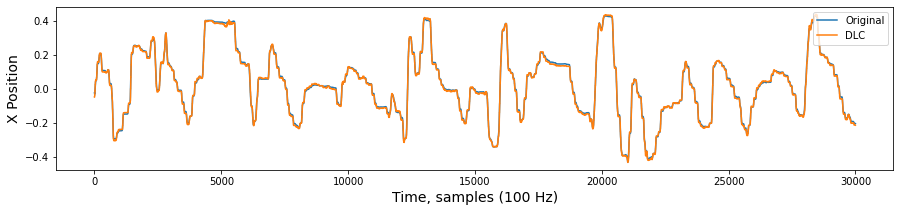

In [51]:
# test centroid position
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(tl[:, 1][:30000], label='Original')
ax.plot(moseq_matrix[:, 2][:30000], label='DLC')
ax.legend(loc='upper right')
ax.set_xlabel('Time, samples (100 Hz)', fontsize=14)
ax.set_ylabel('X Position', fontsize=14)

In [52]:
# save moseq data to the session folder
with h5py.File(moseq_file, 'w') as f:
    ds_h5 = f.create_dataset('moseq', data=moseq_matrix)
    ds_h5.attrs['headers'] = ', '.join(list(ds1.columns))